In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from scipy.stats import ks_2samp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

#### Objective:
Predict **next 7 days Tesla (TSLA) daily closing prices** using historical daily candle close data.

In [2]:
stock_data=yf.download('TSLA',start='2010-06-29')


[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data.head(5)

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [4]:
stock_data.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2026-02-02,421.809998,427.149994,414.500000,421.290009,58739500
2026-02-03,421.959991,428.559998,413.690002,424.269989,56886500
2026-02-04,406.010010,423.899994,399.179993,420.459991,74606900
2026-02-05,397.209991,402.100006,387.529999,397.019989,72819800
2026-02-06,411.109985,414.549988,397.750000,400.869995,62559600


In [5]:
stock_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
count,3927.000000,3927.000000,3927.000000,3927.000000,3.927000e+03
mean,101.290596,103.522482,98.967965,101.321790,9.653459e+07
std,127.690246,130.519344,124.799414,127.794121,7.551480e+07
min,1.053333,1.108667,0.998667,1.076000,1.777500e+06
25%,12.857667,13.028000,12.596000,12.826000,5.150175e+07
50%,20.056000,20.417334,19.650667,20.030001,8.289720e+07
75%,210.441673,215.701668,205.875000,210.034996,1.207733e+08
max,489.880005,498.829987,485.329987,489.880005,9.140820e+08


### Insights

- Price ranged from **~$1 to ~$490**, showing massive long-term growth.
- **75% of data lies below ~$210**, meaning recent highs dominate the averages.
- **Median close (~$20)** is far below the mean, indicating a strong **right-skew** due to recent price surge.
- **Trading volume is very high and volatile**, reflecting strong market interest.


In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3927 entries, 2010-06-29 to 2026-02-06
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   3927 non-null   float64
 1   (High, TSLA)    3927 non-null   float64
 2   (Low, TSLA)     3927 non-null   float64
 3   (Open, TSLA)    3927 non-null   float64
 4   (Volume, TSLA)  3927 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 184.1 KB


### EDA

In [7]:
stock_data.columns=['Close','High','Low','Open','Volume']
stock_data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [8]:
stock_data['Date']=stock_data.index

In [9]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3927 entries, 2010-06-29 to 2026-02-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Close   3927 non-null   float64       
 1   High    3927 non-null   float64       
 2   Low     3927 non-null   float64       
 3   Open    3927 non-null   float64       
 4   Volume  3927 non-null   int64         
 5   Date    3927 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 214.8 KB


In [10]:
stock_data.reset_index(drop=True,inplace=True)
stock_data=stock_data[['Date','Open','High','Low','Close','Volume']]
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3927 non-null   datetime64[ns]
 1   Open    3927 non-null   float64       
 2   High    3927 non-null   float64       
 3   Low     3927 non-null   float64       
 4   Close   3927 non-null   float64       
 5   Volume  3927 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 184.2 KB


In [11]:
fig = px.line(
    stock_data,
    x='Date',
    y=stock_data.columns,
    title='Tesla Stock Data',
    markers=True,
    template='plotly_dark'
)
fig.update_layout(
    title=dict(x=0.5, xanchor='center'),
    xaxis_title='Date',
    yaxis_title='Value (USD)'
)
fig.show()

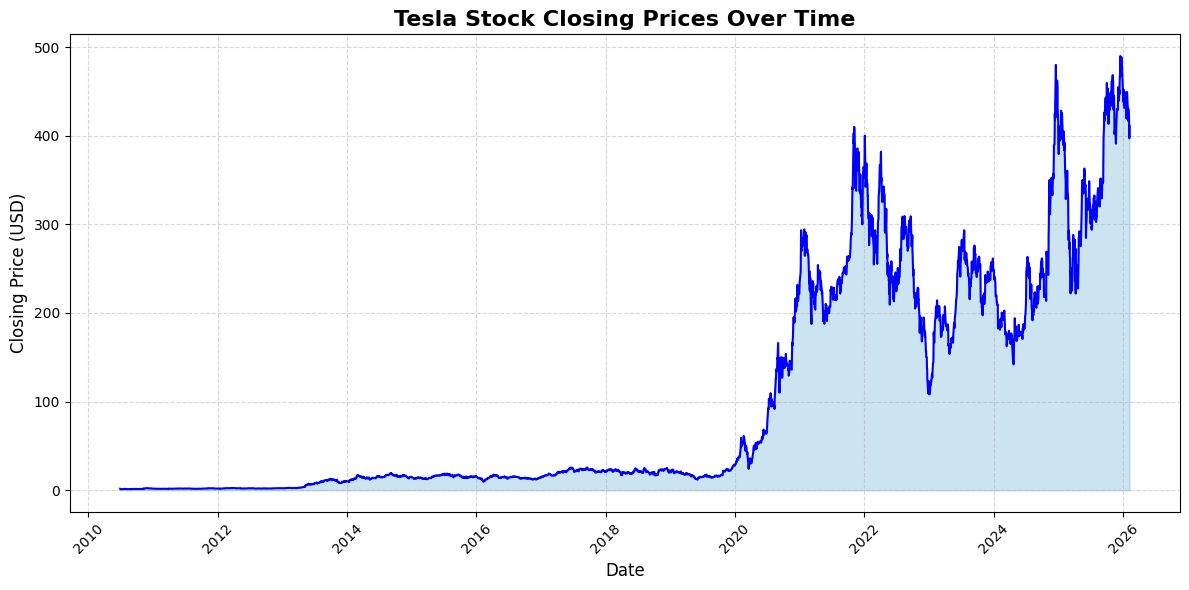

In [12]:
plt.figure(figsize=(12,6))
plt.plot(
    stock_data['Date'], 
    stock_data['Close'], 
    color='blue',  # deep blue
    linewidth=1.5
)
plt.fill_between(
    stock_data['Date'], 
    stock_data['Close'], 
    color='#0077b6', 
    alpha=0.2
)

plt.title('Tesla Stock Closing Prices Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



We will apply **multiplicative model** here.

**Reason:**  The swings in price get bigger as the price rises, especially after 2020.  

So we apply **Classical Decomposition here**.


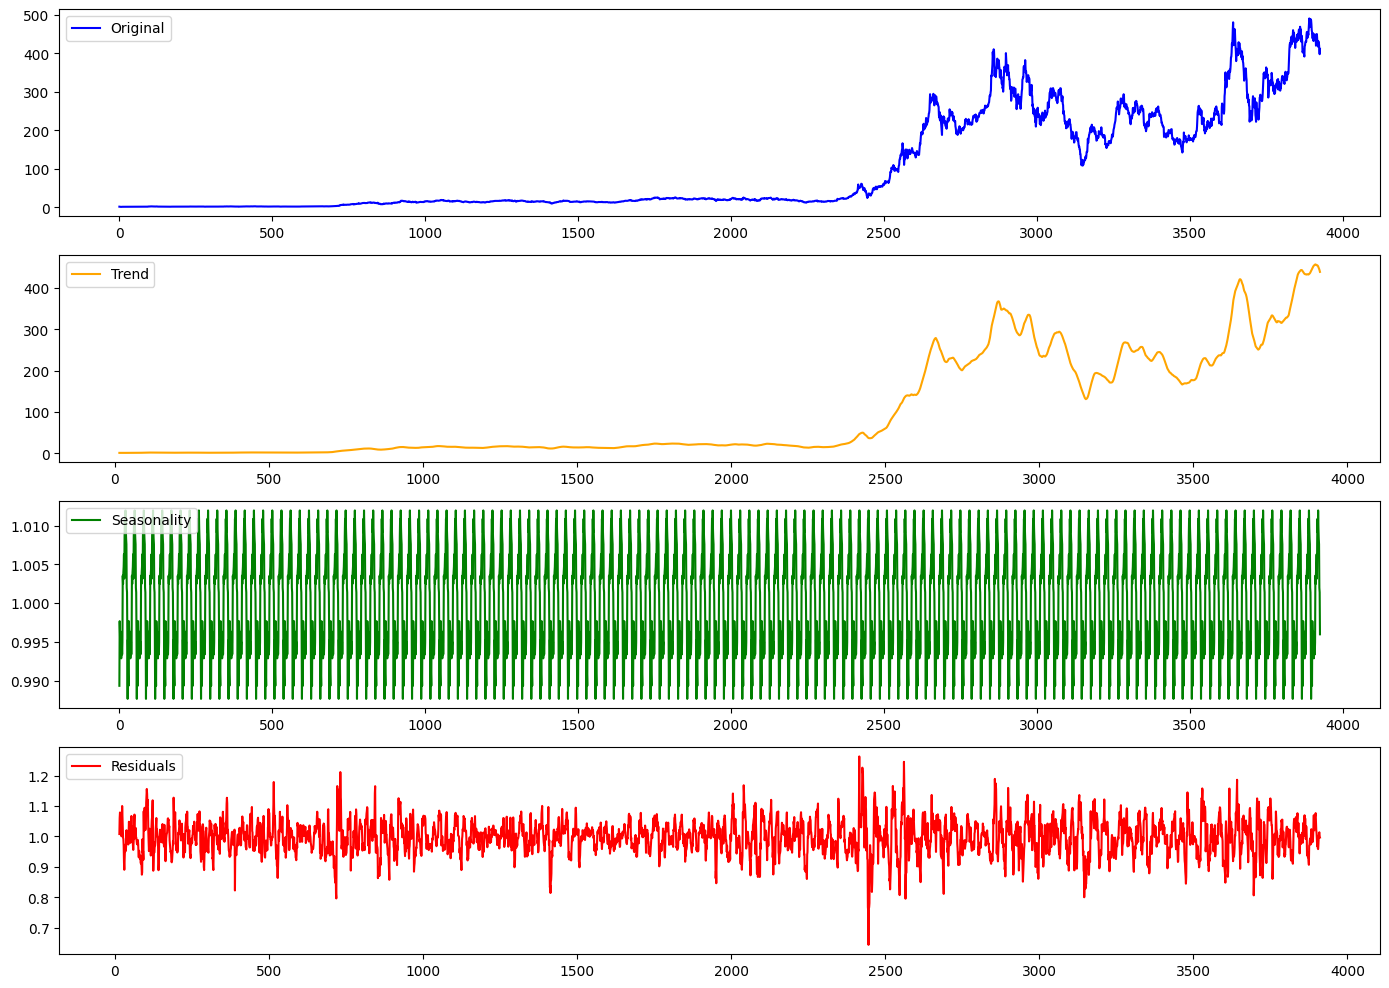

In [13]:
decomposition_multiplicative=seasonal_decompose(
    stock_data['Close'],
    model='multiplicative',
    period=30)
trend_multiplicative=decomposition_multiplicative.trend
seasonal_multiplicative=decomposition_multiplicative.seasonal
residual_multiplicative=decomposition_multiplicative.resid

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(stock_data['Close'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)    
plt.plot(trend_multiplicative, label='Trend', color='orange')
plt.legend(loc='upper left')    
plt.subplot(413)
plt.plot(seasonal_multiplicative, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_multiplicative, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Insights

### Trend (Orange)
- **Observation:** Slow rise until 2019, sharp acceleration from 2020.  
- **Insight:** Confirms long-term bullish trend; non-linear growth makes STL suitable.

### Seasonality (Green)
- **Observation:** Very minor, almost flat.  
- **Insight:** Seasonal effects negligible; price driven mainly by trend and residuals.

### Residuals (Red)
- **Observation:** High volatility, spikes post-2020.  
- **Insight:** Captures unexpected jumps/noise; magnitude rises with price (heteroscedasticity).


# **STATIONARITY CHECK NOW**

In [14]:
adf_test=adfuller(stock_data['Close'])
print("ADF Test Results")
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")

if adf_test[1] < 0.05:
    print("\nStationary Data")
else:
    print("\n Non Stationary Data")

ADF Test Results
ADF Statistic: -0.7155962423286527
P-value: 0.8426682945896031
Critical Values:
   1%: -3.4320295723189704
   5%: -2.8622821430681555
   10%: -2.5671650515903215

 Non Stationary Data


In [15]:
kpss_test=kpss(stock_data['Close'],regression='ct',nlags="auto")
print("\nKPSS Test Results")
print(f"KPSS Statistic: {kpss_test[0]}")
print(f"P-value: {kpss_test[1]}")
print("Critical Values:")
for key, value in kpss_test[3].items():
    print(f"   {key}: {value}")

if kpss_test[1] < 0.05:
    print("\n Non Stationary Data") 
else:
    print("\nStationary Data")


KPSS Test Results
KPSS Statistic: 1.2882204478250727
P-value: 0.01
Critical Values:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216

 Non Stationary Data


Since the data is **not stationary** based on both the **ADF** and **KPSS** tests, it also **fails the KS test**.  
Therefore, we need to **convert the data into a stationary form** before proceeding further.

To achieve stationarity, we have **four standard methods**:

1. **Differencing**  
2. **Transformation**  
3. **Detrending**  
4. **Seasonality Adjustment**

We will begin with **Differencing** and continue applying the remaining methods **until the data becomes stationary**.

In [16]:
def adf_check(series):
    result=adfuller(series)
    print("ADF Test Results")
    print(f"ADF Statistic: {result[0]}")
    print(f"P-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print("Stationary Data")
    else:
        print("Non Stationary Data")

def kpss_check(series):
    result=kpss(series,regression='c',nlags="auto")
    print("\nKPSS Test Results")
    print(f"KPSS Statistic: {result[0]}")
    print(f"P-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[3].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print("Non Stationary Data") 
    else:
        print("Stationary Data")

In [17]:
prices = stock_data['Close'].diff().dropna()

adf_check(prices)
kpss_check(prices)

ADF Test Results
ADF Statistic: -11.099308553214593
P-value: 3.90146192116869e-20
Critical Values:
   1%: -3.4320295723189704
   5%: -2.8622821430681555
   10%: -2.5671650515903215
Stationary Data

KPSS Test Results
KPSS Statistic: 0.11793203055084875
P-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Stationary Data


Since the data **became stationary after first-order differencing**, there is **no need to apply the remaining three methods**.  

As we are working with the **entire distribution of the data**, checking for **strict stationarity** is ideal. However, in stock data, due to **high volatility and market fluctuations**, achieving perfect strict stationarity is **practically impossible**.  

We will first check strict stationarity using the **first-order differenced data**, and then apply a **log transformation** to further stabilize the distribution. This approach allows us to assess whether the data comes closest to strict stationarity while preserving the weak stationarity already achieved.


In [18]:
mid=len(prices)//2
first_half = prices.iloc[:mid]
second_half = prices.iloc[mid:]
ks_stat, p_value = ks_2samp(first_half, second_half)
print("KS Statistic:", ks_stat)
print("P-value:", p_value)
if p_value > 0.05:
    print("Distributions are similar so Strict stationarity holds")
else:
    print("Distributions differ so Strict stationarity violated")

KS Statistic: 0.3601630157921549
P-value: 1.6604876397230213e-113
Distributions differ so Strict stationarity violated


**log transformation**

In [19]:
log_returns = np.log(stock_data['Close']).diff().dropna()
mid=len(log_returns)//2
first_half = log_returns.iloc[:mid]
second_half = log_returns.iloc[mid:]
ks_stat, p_value = ks_2samp(first_half, second_half)
print("KS Statistic:", ks_stat)
print("P-value:", p_value)
if p_value > 0.05:
    print("Distributions are similar so Strict stationarity holds")
else:
    print("Distributions differ so Strict stationarity violated")


KS Statistic: 0.06673458991339785
P-value: 0.0003180336802102084
Distributions differ so Strict stationarity violated


As expected, the data **does not achieve strict stationarity**. We will proceed with the **weakly stationary data** for forecasting purposes.

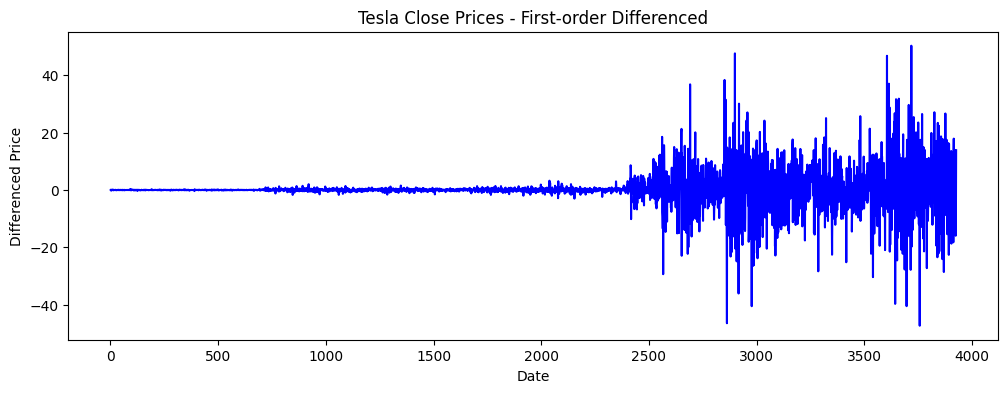

In [20]:
plt.figure(figsize=(12,4))
plt.plot(prices, color='blue')
plt.title("Tesla Close Prices - First-order Differenced")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.show()

In [21]:
lb_test = acorr_ljungbox(prices, lags=[10,20,30], return_df=True)
print("Ljung-Box Test Results (Differenced Prices):")
print(lb_test)

Ljung-Box Test Results (Differenced Prices):
       lb_stat     lb_pvalue
10   33.702890  2.073626e-04
20   79.982416  3.953007e-09
30  134.285719  3.778485e-15


In [22]:
for lag in [10,20,30]:
    p_value = lb_test['lb_pvalue'][lag]
    if p_value > 0.05:
        print(f"Lag {lag}: White Noise and No Autocorrelation exists")
    else:
        print(f"Lag {lag}: Random Walk and Autocorrelation Exists")

Lag 10: Random Walk and Autocorrelation Exists
Lag 20: Random Walk and Autocorrelation Exists
Lag 30: Random Walk and Autocorrelation Exists


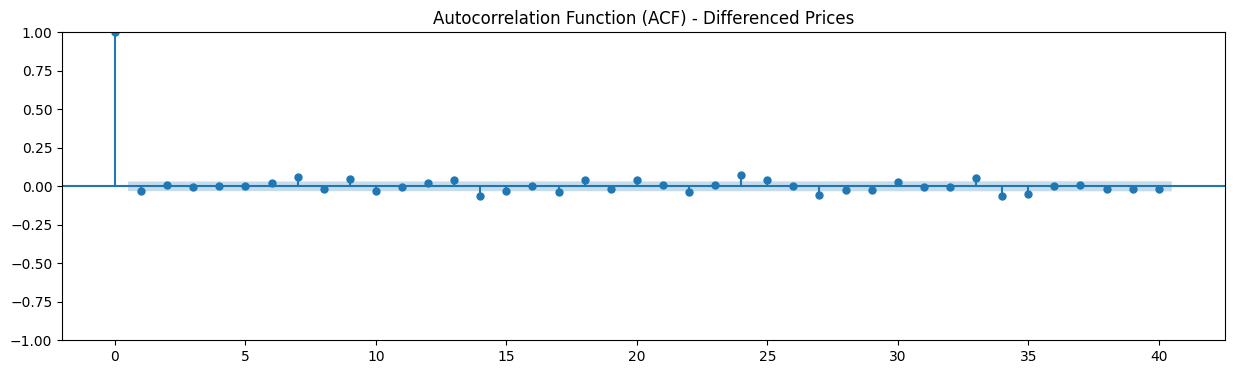

In [23]:
fig, ax = plt.subplots(figsize=(15,4))
plot_acf(prices, lags=40, ax=ax)
plt.title("Autocorrelation Function (ACF) - Differenced Prices")
plt.show()

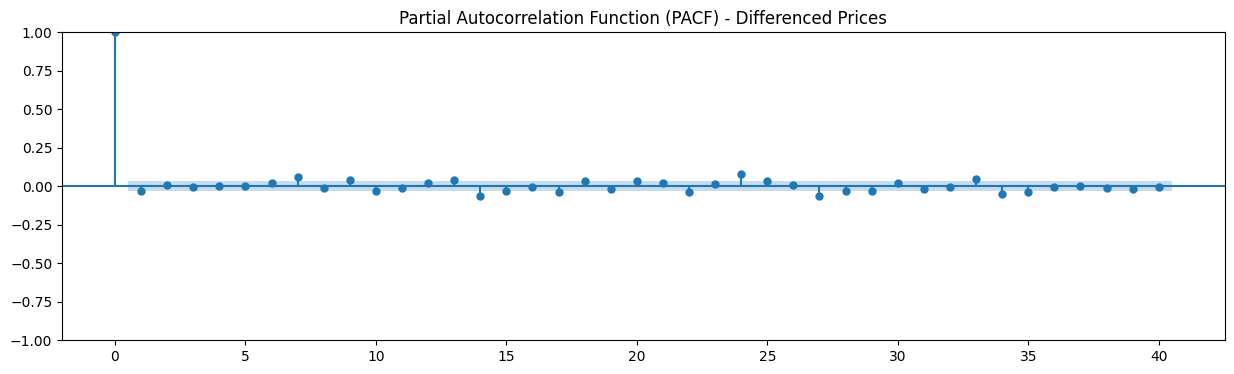

In [24]:
fig, ax = plt.subplots(figsize=(15,4))
plot_pacf(prices, lags=40, ax=ax)
plt.title("Partial Autocorrelation Function (PACF) - Differenced Prices")
plt.show()

**Insights from ACF and PACF (Differenced Prices):**
- Series is stationary after first differencing (d = 1). 
- ACF is mostly flat → MA component likely 0 (q ≈ 0).  
- PACF is mostly flat → AR component likely 0 (p ≈ 0).  
- Ljung-Box test p-values < 0.05 → minor autocorrelation present.


## Modeling Approach

Now we will use our series to try **5 univariate time series models**:

- **AR** (Autoregressive)  
- **MA** (Moving Average)  
- **ARMA** (Autoregressive Moving Average)  
- **ARIMA** (Autoregressive Integrated Moving Average)  
- **SARIMA** (Seasonal ARIMA)

Then we will try **classical machine learning models** on lag features:

- **Random Forest**  
- **XGBoost**  
- **SVM** (Support Vector Machine)  

Finally, we will use **neural networks** for sequence modeling:

- **LSTM** (Long Short-Term Memory)  
- **GRU** (Gated Recurrent Unit)
